In [1]:

import pandas as pd

data = pd.read_csv('data.csv')

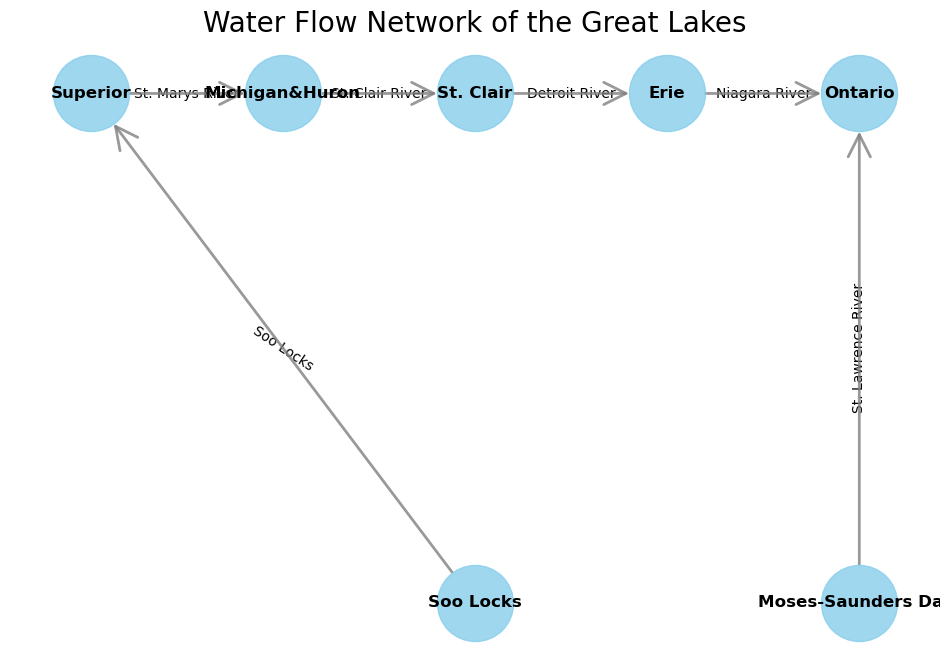

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
water_flow_graph = nx.DiGraph()

# Add nodes
lakes_and_dams = ['Superior', 'Michigan&Huron', 'St. Clair', 'Erie', 'Ontario', 'Soo Locks', 'Moses-Saunders Dam']
water_flow_graph.add_nodes_from(lakes_and_dams)

# Update edge attributes, replace flow capacity with river names, and add dam impacts on water levels
edges_with_rivers = [
    ('Superior', 'Michigan&Huron', {'river': 'St. Marys River'}),
    ('Michigan&Huron', 'St. Clair', {'river': 'St. Clair River'}),
    ('St. Clair', 'Erie', {'river': 'Detroit River'}),
    ('Erie', 'Ontario', {'river': 'Niagara River'}),
    ('Soo Locks', 'Superior', {'river': 'Soo Locks'}),
    ('Moses-Saunders Dam', 'Ontario', {'river': 'St. Lawrence River'})
]
water_flow_graph.add_edges_from(edges_with_rivers)

# Draw the network graph with enhanced visual features
plt.figure(figsize=(12, 8))
positions = {
    'Superior': (0, 2),
    'Michigan&Huron': (1, 2),
    'St. Clair': (2, 2),
    'Erie': (3, 2),
    'Ontario': (4, 2),
    'Soo Locks': (2, 0),
    'Moses-Saunders Dam': (4, 0)
}

# Node labels
node_labels = {node: node for node in lakes_and_dams}
nx.draw_networkx_labels(water_flow_graph, positions, labels=node_labels, font_size=12, font_color='black', font_weight='bold')

# Edge labels (showing river names)
edge_labels = {(u, v): data['river'] for u, v, data in water_flow_graph.edges(data=True)}
nx.draw_networkx_edge_labels(water_flow_graph, positions, edge_labels=edge_labels, font_size=10)

# Draw the graph with enhanced visual features
nx.draw_networkx(water_flow_graph, positions, with_labels=False, node_size=3000, node_color='skyblue', edge_color='gray', width=2, arrowstyle='->', arrowsize=40, alpha=0.8)

plt.title("Water Flow Network of the Great Lakes", size=20)
plt.axis("off")  # Turn off the axis
plt.show()


In [4]:
import numpy as np
from scipy.optimize import minimize

optimized_results = []
nodes = ['Superior', 'Michigan&Huron', 'St. Clair', 'Erie', 'Ontario']
# Assumed ideal water levels and maximum river flow capacities
ideal_levels = {'Superior': 183.35, 'Michigan&Huron': 176.33, 'St. Clair': 175.10, 'Erie': 174.28, 'Ontario': 74.83}
max_flow_capacity = {'St. Marys River': 3191.308305, 'St. Clair River': 7011.250543, 'Detroit River': 7676.696374, 'Niagara River': 8070.000000}

temp_data = data
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    Marys_flow = temp_data[temp_data['Source'] == "St. Mary's River - Flow "][month].iloc[0]
    Clair_flow = temp_data[temp_data['Source'] == 'St. Clair River - Flow '][month].iloc[0]
    Detroit_flow = temp_data[temp_data['Source'] == 'Detroit River - Flow '][month].iloc[0]
    Niagara_flow = temp_data[temp_data['Source'] == 'Niagara River - Flow at Buffalo'][month].iloc[0]

    # Adjust initial flows based on the impact of dams
    initial_flows = np.array([Marys_flow, Clair_flow, Detroit_flow, Niagara_flow])

    def objective(flows):
        # Original objective function, minimize the total water level deviation
        return sum(abs(ideal_levels[node] - flows[i] / max_flow_capacity[river]) for i, (node, river) in enumerate(zip(nodes, max_flow_capacity.keys())))

    # Constraints
    constraints = []

    # Non-negativity constraint on flows
    bounds = [(0, max_flow_capacity[river]) for river in max_flow_capacity]

    # Solve the optimization problem
    result = minimize(objective, initial_flows, bounds=bounds, method='SLSQP')
    optimized_levels = result.x
    objective_value = objective(initial_flows)
    optimized_results.append([month, result.fun])

# Store the results in a DataFrame for further analysis or storage
result_df = pd.DataFrame(optimized_results, columns=['Month', 'Objective_Value'])
result_df


,Month,Objective_Value
0,Jan,706.350740
1,Feb,706.441289
2,Mar,706.260180
3,Apr,706.195426
4,May,706.136121
5,Jun,706.033461
6,Jul,705.961801
7,Aug,705.966152
8,Sep,706.028225
9,Oct,706.063307


In [5]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd

# Percentage impact of environmental conditions change (positive for increase, negative for decrease)
environmental_impact_percentage_increase = {
    'St. Marys River': 0.5,  # 50% increase in flow
    'St. Clair River': 0.5,  # 50% increase in flow
    'Detroit River': 0.5,  # 50% increase in flow
    'Niagara River': 0.5  # 50% increase in flow
}

environmental_impact_percentage_decrease = {
    'St. Marys River': -0.5,  # 50% decrease in flow
    'St. Clair River': -0.5,  # 50% decrease in flow
    'Detroit River': -0.5,  # 50% decrease in flow
    'Niagara River': -0.5  # 50% decrease in flow
}

optimized_results_no_impact = []
optimized_results_increase = []
optimized_results_decrease = []

data = pd.read_csv('data.csv')  # Ensure the path is correct

# Assumed ideal water levels and maximum river flow capacities
ideal_levels = {'Superior': 183.35, 'Michigan&Huron': 176.33, 'St. Clair': 175.10, 'Erie': 174.28}
max_flow_capacity = {'St. Marys River': 3191.308305, 'St. Clair River': 7011.250543, 'Detroit River': 7676.696374, 'Niagara River': 8070.000000}

# Iterate through months
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    Marys_flow = data[data['Source'] == "St. Mary's River - Flow "][month].mean(numeric_only=True)
    Clair_flow = data[data['Source'] == 'St. Clair River - Flow '][month].mean(numeric_only=True)
    Detroit_flow = data[data['Source'] == 'Detroit River - Flow '][month].mean(numeric_only=True)
    Niagara_flow = data[data['Source'] == 'Niagara River - Flow at Buffalo'][month].mean(numeric_only=True)

    # Adjust initial flows based on the impact of environmental conditions (no impact)
    initial_flows_no_impact = np.array([Marys_flow, Clair_flow, Detroit_flow, Niagara_flow])

    # Adjust initial flows based on the impact of environmental conditions (increase)
    initial_flows_increase = np.array([
        Marys_flow * (1 + environmental_impact_percentage_increase['St. Marys River']),
        Clair_flow * (1 + environmental_impact_percentage_increase['St. Clair River']),
        Detroit_flow * (1 + environmental_impact_percentage_increase['Detroit River']),
        Niagara_flow * (1 + environmental_impact_percentage_increase['Niagara River'])
    ])

    # Adjust initial flows based on the impact of environmental conditions (decrease)
    initial_flows_decrease = np.array([
        Marys_flow * (1 + environmental_impact_percentage_decrease['St. Marys River']),
        Clair_flow * (1 + environmental_impact_percentage_decrease['St. Clair River']),
        Detroit_flow * (1 + environmental_impact_percentage_decrease['Detroit River']),
        Niagara_flow * (1 + environmental_impact_percentage_decrease['Niagara River'])
    ])

    # Objective function: Minimize the total water level deviation

    # No impact scenario
    def objective_no_impact(flows):
        return sum(abs(ideal_levels[node] - flows[i] / max_flow_capacity[river]) for i, (node, river) in enumerate(zip(ideal_levels.keys(), max_flow_capacity)))

    # Increase flow scenario
    def objective_increase(flows):
        return sum(abs(ideal_levels[node] - flows[i] / max_flow_capacity[river]) for i, (node, river) in enumerate(zip(ideal_levels.keys(), max_flow_capacity)))

    # Decrease flow scenario
    def objective_decrease(flows):
        return sum(abs(ideal_levels[node] - flows[i] / max_flow_capacity[river]) for i, (node, river) in enumerate(zip(ideal_levels.keys(), max_flow_capacity)))

    # Update flow constraints
    bounds = [(0, None) for _ in max_flow_capacity]  # To simplify, no upper bounds are considered here, but in practice, physical upper bounds should be taken into account

    # Solve the optimization problems
    result_no_impact = minimize(objective_no_impact, initial_flows_no_impact, bounds=bounds, method='SLSQP')
    result_increase = minimize(objective_increase, initial_flows_increase, bounds=bounds, method='SLSQP')
    result_decrease = minimize(objective_decrease, initial_flows_decrease, bounds=bounds, method='SLSQP')

    # Store the results
    optimized_results_no_impact.append([month, result_no_impact.fun])
    optimized_results_increase.append([month, result_increase.fun])
    optimized_results_decrease.append([month, result_decrease.fun])

# Store the results in DataFrames
result_df1 = pd.DataFrame(optimized_results_no_impact, columns=['Month', 'Objective_Value'])
result_df2 = pd.DataFrame(optimized_results_increase, columns=['Month', 'Objective_Value'])
result_df3 = pd.DataFrame(optimized_results_decrease, columns=['Month', 'Objective_Value'])

# Add labels to distinguish between scenarios
result_df1['Scenario'] = 'No_Environmental_Impact'
result_df2['Scenario'] = 'Flow_Increase'
result_df3['Scenario'] = 'Flow_Decrease'

# Concatenate the results
final_results = pd.concat([result_df1, result_df2, result_df3], ignore_index=True)

final_results


,Month,Objective_Value,Scenario
0,Jan,706.267540,No_Environmental_Impact
1,Feb,706.341095,No_Environmental_Impact
2,Mar,706.153082,No_Environmental_Impact
3,Apr,706.096825,No_Environmental_Impact
4,May,706.043420,No_Environmental_Impact
5,Jun,705.969851,No_Environmental_Impact
6,Jul,705.913474,No_Environmental_Impact
7,Aug,705.924728,No_Environmental_Impact
8,Sep,705.987628,No_Environmental_Impact
9,Oct,706.006423,No_Environmental_Impact


In [6]:
#夏季干旱或蒸发率增加：可能导致St. Clair River和Niagara River流量减少，因为这两条河流所在的地区可能受到夏季干旱和高蒸发率的影响。

import numpy as np
from scipy.optimize import minimize
import pandas as pd




# 假设环境条件变化的百分比影响（正数表示增加，负数表示减少）
environmental_impact_percentage = {
    'St. Marys River': -0.5,  # 流量减少50%
    'St. Clair River':-0.5,  #  流量减少50%
    'Detroit River':-0.5,  #  流量减少50%
    'Niagara River': -0.5,  #  流量减少50%
}


# 假设环境条件变化的百分比影响（正数表示增加，负数表示减少）
environmental_impact_percentage = {
    'St. Marys River': +0.5,  # 流量减少50%
    'St. Clair River':+0.5,  #  流量减少50%
    'Detroit River':+0.5,  #  流量减少50%
    'Niagara River': +0.5,  #  流量减少50%
}


newdf = []
data = pd.read_csv('data.csv')  # 确保这里的路径是正确的


# 假设的理想水位和河流最大容量
ideal_levels = {'Superior': 183.35, 'Michigan&Huron': 176.33, 'St. Clair': 175.10, 'Erie': 174.28}
max_flow_capacity = {'St. Marys River': 3191.308305, 'St. Clair River': 7011.250543, 'Detroit River': 7676.696374, 'Niagara River': 8070.000000}

# 加载数据


for dd in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    Marys = data[data['Source'] == "St. Mary's River - Flow "][dd].mean(numeric_only=True)
    Clair = data[data['Source'] == 'St. Clair River - Flow '][dd].mean(numeric_only=True)
    Detroit = data[data['Source'] == 'Detroit River - Flow '][dd].mean(numeric_only=True)
    Niagara = data[data['Source'] == 'Niagara River - Flow at Buffalo'][dd].mean(numeric_only=True)

    # 根据大坝的影响调整初始流量
    initial_flows = np.array([
        Marys * (1 + environmental_impact_percentage['St. Marys River']),
        Clair * (1 + environmental_impact_percentage['St. Clair River']),
        Detroit * (1 + environmental_impact_percentage['Detroit River']),
        Niagara * (1 + environmental_impact_percentage['Niagara River'])
    ])

    # 目标函数：最小化水位差异总和
    def objective(flows):
        return sum(abs(ideal_levels[node] - flows[i] / max_flow_capacity[river]) for i, (node, river) in enumerate(zip(ideal_levels.keys(), max_flow_capacity)))

    # 更新流量约束，考虑环境条件变化的百分比影响
    bounds = [(0, None) for _ in max_flow_capacity]  # 为简化，这里不限制上界，但实际应用中可能需要考虑物理上界

    # 求解优化问题
    result = minimize(objective, initial_flows, bounds=bounds, method='SLSQP')
    optimized_levels = result.x
    objective_value = objective(optimized_levels)
    newdf.append([dd, result.fun])

# 将结果存储在DataFrame中
result_df3 = pd.DataFrame(newdf, columns=[ 'Month', 'Objective_Value'])
result_df3


,Month,Objective_Value
0,Jan,704.871310
1,Feb,704.981642
2,Mar,704.699623
3,Apr,704.615237
4,May,704.535131
5,Jun,704.424777
6,Jul,704.340211
7,Aug,704.357093
8,Sep,704.451442
9,Oct,704.479635


In [7]:
result_df1['Month']='No_Environmental_Impact'
result_df2['Month']='Flow_Increase'
result_df3['Month']='Flow_Decrease'

In [8]:
# Concatenate the DataFrames vertically
dta = pd.concat([result_df1, result_df2, result_df3], axis=0)

# Check the current column names
print(dta.columns)

# Rename the columns
dta.columns = ['Month', 'Objective_Value', 'Scenario']

# Display the resulting DataFrame
dta


Index(['Month', 'Objective_Value', 'Scenario'], dtype='object')


,Month,Objective_Value,Scenario
0,No_Environmental_Impact,706.267540,No_Environmental_Impact
1,No_Environmental_Impact,706.341095,No_Environmental_Impact
2,No_Environmental_Impact,706.153082,No_Environmental_Impact
3,No_Environmental_Impact,706.096825,No_Environmental_Impact
4,No_Environmental_Impact,706.043420,No_Environmental_Impact
5,No_Environmental_Impact,705.969851,No_Environmental_Impact
6,No_Environmental_Impact,705.913474,No_Environmental_Impact
7,No_Environmental_Impact,705.924728,No_Environmental_Impact
8,No_Environmental_Impact,705.987628,No_Environmental_Impact
9,No_Environmental_Impact,706.006423,No_Environmental_Impact


In [9]:
dta.to_csv('Q4.csv',index=None)

In [10]:
import pandas as pd
from scipy import stats

# Assuming 'Scenario' column represents the classes
scenarios = ['No_Environmental_Impact', 'Flow_Increase', 'Flow_Decrease']

# Exclude scenarios with no data
valid_scenarios = [scenario for scenario in scenarios if len(dta[dta['Scenario'] == scenario]['Objective_Value'].values) > 0]

# Print data for each valid scenario
for scenario in valid_scenarios:
    scenario_data = dta[dta['Scenario'] == scenario]['Objective_Value'].values
    print(f"{scenario} data: {scenario_data}")

# Perform ANOVA test only if there are at least two valid scenarios
if len(valid_scenarios) >= 2:
    f_value, p_value = stats.f_oneway(*[dta[dta['Scenario'] == scenario]['Objective_Value'].values for scenario in valid_scenarios])
    print(f"F-value: {f_value}, P-value: {p_value}")
else:
    print("Cannot perform ANOVA as there are not enough valid scenarios.")


No_Environmental_Impact data: [706.26753993 706.34109469 706.15308184 706.09682486 706.04342037
 705.96985132 705.9134739  705.92472847 705.98762767 706.00642343
 706.02890629 706.11078532]
Flow_Increase data: [704.87130989 704.98164204 704.69962276 704.61523729 704.53513056
 704.42477697 704.34021085 704.35709271 704.45144151 704.47963514
 704.51335943 704.63617798]
F-value: 476.0290663982253, P-value: 2.1459573356782747e-16
